# **Sentiment analysis on imdb dataset using LSTM.**


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
!pip install wget
import wget

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=eaf919f7bc291268f67783a063df61c3c4d4229edff44dd6a4b80e6569fd63d8
  Stored in directory: /root/.cache/pip/wheels/90/1d/93/c863ee832230df5cfc25ca497b3e88e0ee3ea9e44adc46ac62
Successfully built wget


In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
path = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
path1 = '../input/imdb-dataset/Test.csv'
df = pd.read_csv(path)
df1= pd.read_csv(path1)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Splitting to train and test data

In [4]:
X,y = df['review'].values,df['sentiment'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')


shape of train data is (37500,)
shape of test data is (12500,)


### EDA

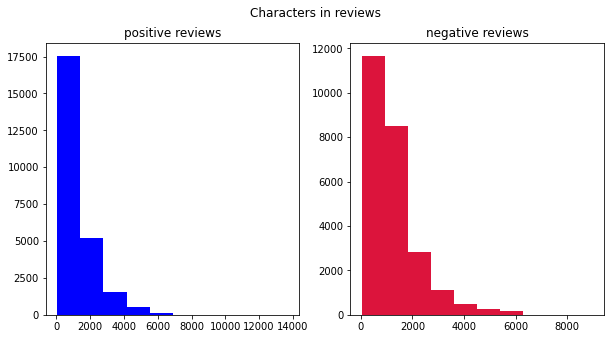

In [5]:
#Number of characters in reviews

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
review_len=df[df['sentiment']=="positive"]['review'].str.len()
ax1.hist(review_len,color='blue')
ax1.set_title('positive reviews')
review_len=df[df['sentiment']=="negative"]['review'].str.len()
ax2.hist(review_len,color='CRIMSON')
ax2.set_title('negative reviews')
fig.suptitle('Characters in reviews')
plt.show()

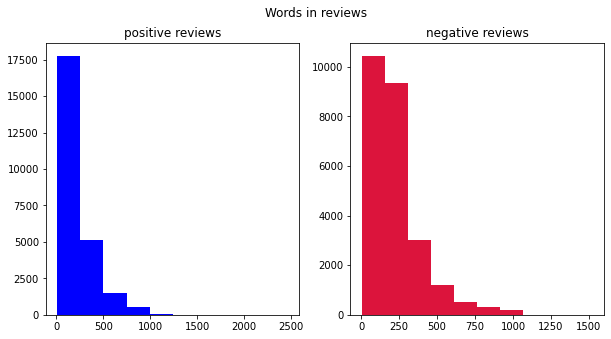

In [6]:
#Number of words in reviews
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
review_len=df[df['sentiment']=="positive"]['review'].str.split().map(lambda x: len(x))
ax1.hist(review_len,color='blue')
ax1.set_title('positive reviews')
review_len=df[df['sentiment']=="negative"]['review'].str.split().map(lambda x: len(x))
ax2.hist(review_len,color='CRIMSON')
ax2.set_title('negative reviews')
fig.suptitle('Words in reviews')
plt.show()

Text(0.5, 0.98, 'Average word length in each review')

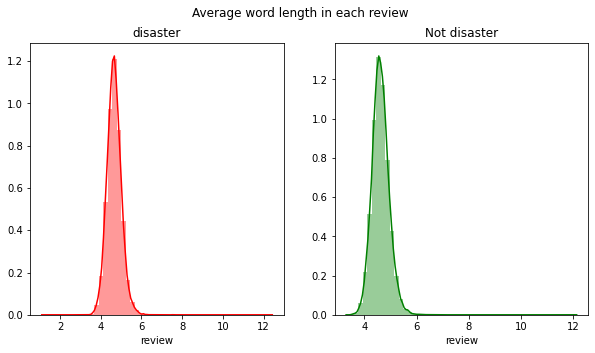

In [7]:
#Average word length in a review
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['sentiment']=="positive"]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=df[df['sentiment']=="negative"]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each review')

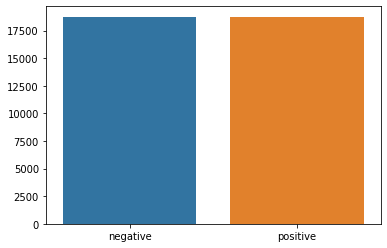

In [8]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tockenization

In [9]:
def preprocess_string(review):
    """
    we tried to run the model with/without the removing of the html tags and urls. 
    the accruacy without removing them was better.with removing them the val_accrucay was 50%. 
    
    #Removing HTML tag from review
    
    clean = re.compile('<.*?>')
    review_without_tag = re.sub(clean, '', review) 
    
    
   
    #Removing URLs
    
    review_without_tag_and_url = re.sub(r"http\S+", "", review_without_tag)
    
    review_without_tag_and_url = re.sub(r"www\S+", "", review_without_tag)
    """   
    # Remove all non-word characters (everything except numbers and letters)
    review = re.sub(r"[^\w\s]", '', review)
    # Replace all runs of whitespaces with no space
    review = re.sub(r"\s+", '', review)
    # replace digits with no space
    review = re.sub(r"\d", '', review)
    return review

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [10]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [11]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

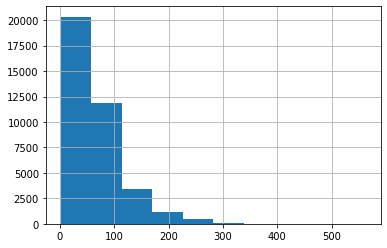

count    37500.000000
mean        69.220987
std         47.954123
min          2.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        562.000000
dtype: float64

In [12]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

### Padding

Padding each of the sequence to max length. 

In [13]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [14]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)



### Batching and loading as tensor

In [15]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


In [16]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  54, 126, 126],
        [  0,   0,   0,  ...,  13,  45, 234],
        [  0,   0,   0,  ..., 749, 945, 221],
        ...,
        [  0,   0,   0,  ..., 129,   1, 953],
        [  0,   0,   0,  ...,   2,  62,  46],
        [  0,   0,   0,  ..., 251,  53, 251]])
Sample input: 
 tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0])


### Model

In [17]:
class Main_LSTM(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(Main_LSTM,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [18]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = Main_LSTM(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


Main_LSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [19]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [20]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.6533555413484573 val_loss : 0.6903057191371917
train_accuracy : 59.165333333333336 val_accuracy : 50.064
Validation loss decreased (inf --> 0.690306).  Saving model ...
Epoch 2
train_loss : 0.506926111916701 val_loss : 0.3776338608264923
train_accuracy : 74.70133333333334 val_accuracy : 82.816
Validation loss decreased (0.690306 --> 0.377634).  Saving model ...
Epoch 3
train_loss : 0.3512411891619364 val_loss : 0.34157102251052857
train_accuracy : 84.896 val_accuracy : 85.288
Validation loss decreased (0.377634 --> 0.341571).  Saving model ...
Epoch 4
train_loss : 0.3157070444623629 val_loss : 0.34317318308353423
train_accuracy : 86.50666666666666 val_accuracy : 85.56
Epoch 5
train_loss : 0.29172972386082013 val_loss : 0.3314902265071869
train_accuracy : 87.62933333333334 val_accuracy : 85.72800000000001
Validation loss decreased (0.341571 --> 0.331490).  Saving model ...


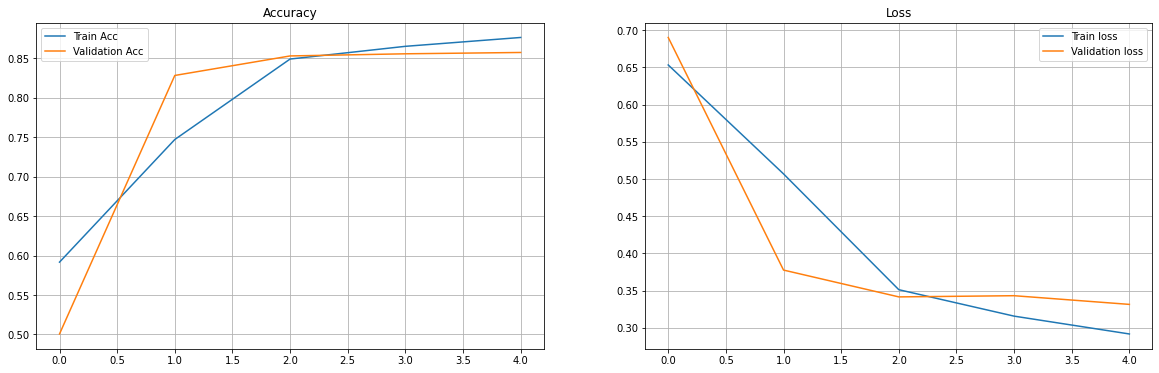

In [21]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Classification Report:
              precision    recall  f1-score   support

           1     0.8295    0.8994    0.8630      6250
           0     0.8901    0.8152    0.8510      6250

    accuracy                         0.8573     12500
   macro avg     0.8598    0.8573    0.8570     12500
weighted avg     0.8598    0.8573    0.8570     12500



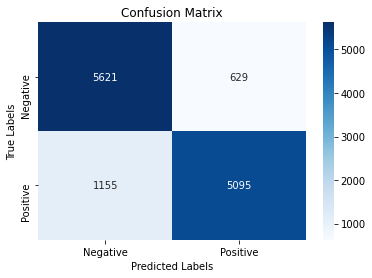

In [22]:
# Evaluation Function
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def evaluate(model,valid_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    val_h = model.init_hidden(batch_size)
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader :
            
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    
    

evaluate(model, valid_loader)

### Inferance

# Predicting the unlabeled datset

In [23]:
outputs = list()
status = list()
for review in df1['Review'][:] :
    #print(text)
    word_seq = np.array([vocab[preprocess_string(word)] for word in review.split() 
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,500))
    inputs = pad.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    #print(output.item())
    pro = output.item()
    outputs.append(pro)


df1['outputs'] = outputs


In [24]:

df1['outputs'] = df1['outputs'].astype(float)  
predicted_sentiment = list()
df1.head(10)
for i in df1['outputs'][:] : 
    if i < 0.5 : 
        predicted_sentiment.append('Negative') 
    else : 
        predicted_sentiment.append('Positive')

df1['predicted_sentiment'] = predicted_sentiment    
        
        
print(df1.shape)
print(df1['predicted_sentiment'].value_counts())

(2000, 4)
Positive    1086
Negative     914
Name: predicted_sentiment, dtype: int64


In [25]:
df1_pos = df1[df1['predicted_sentiment']=='Positive']
df1_neg = df1[df1['predicted_sentiment']=='Negative']
print(df1_pos.shape)
print(df1_neg.shape)

(1086, 4)
(914, 4)


# Wordclouds for predicted reviews

In [26]:
import pandas as pd
import numpy as np

#for plotting images & adjusting colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from matplotlib.pyplot import figure


In [27]:
STOPWORDS.add('https')  # remove htps to the world Cloud

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

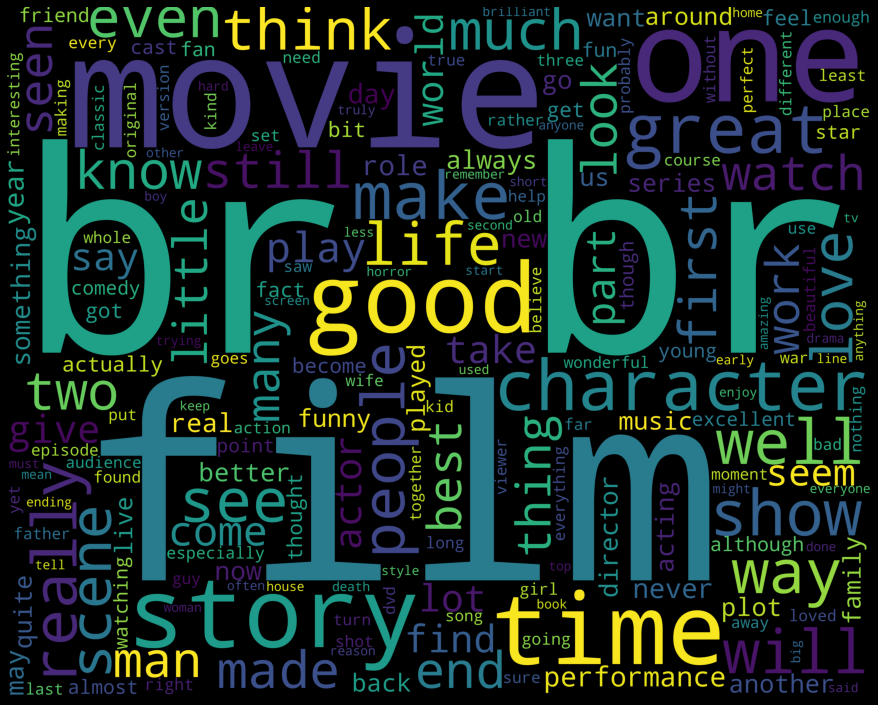

In [28]:
text = df1_pos.Review.values

Plot_world(text)

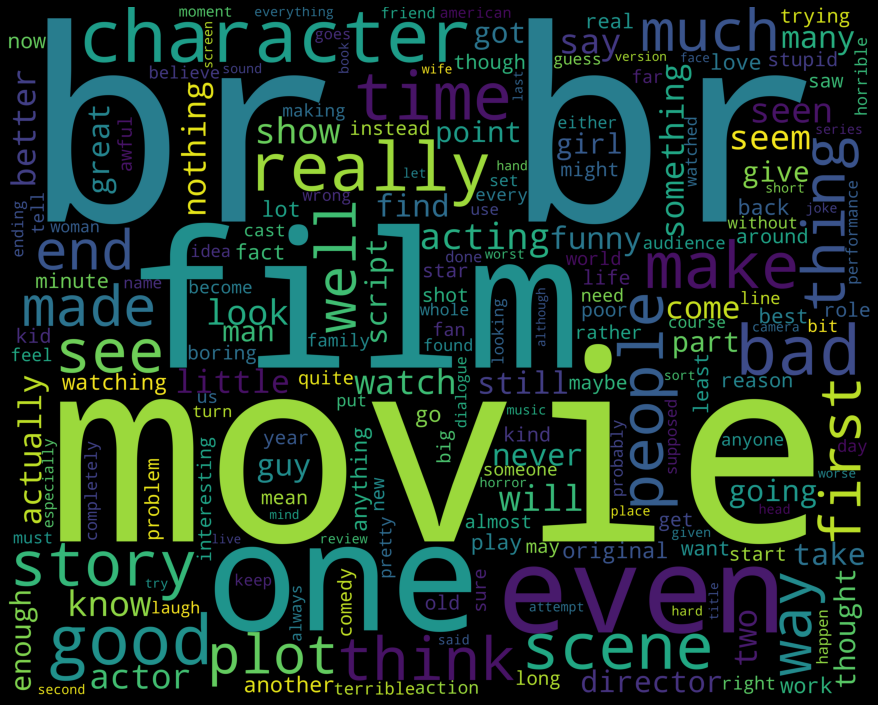

In [29]:
text = df1_neg.Review.values

Plot_world(text)


# single Predictions

In [30]:
def predict_single_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [31]:

index = 22
index_text = df['review'][index] 
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_single_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

What an absolutely stunning movie, if you have 2.5 hrs to kill, watch it, you won't regret it, it's too much fun! Rajnikanth carries the movie on his shoulders and although there isn't anything more other than him, I still liked it. The music by A.R.Rehman takes time to grow on you but after you heard it a few times, you really start liking it.
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.8788690567016602


In [32]:

index = 42
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_single_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

Of all the films I have seen, this one, The Rage, has got to be one of the worst yet. The direction, LOGIC, continuity, changes in plot-script and dialog made me cry out in pain. "How could ANYONE come up with something so crappy"? Gary Busey is know for his "B" movies, but this is a sure "W" movie. (W=waste).<br /><br />Take for example: about two dozen FBI & local law officers surround a trailer house with a jeep wagoneer. Inside the jeep is MA and is "confused" as to why all the cops are about. Within seconds a huge gun battle ensues, MA being killed straight off. The cops blast away at the jeep with gary and company blasting away at them. The cops fall like dominoes and the jeep with Gary drives around in circles and are not hit by one single bullet/pellet. MA is killed and gary seems to not to have noticed-damn that guy is tough. Truly a miracle, not since the six-shooter held 300 bullets has there been such a miracle.
Actual sentiment is  : negative
predicted sentiment is negativ